# Pierce County Jail Records

This notebook analyzes inmate booking and release records disclosed by Pierce County Corrections. The records include all inmates released from Pierce County Jail from October 1, 2016 to July 31, 2018.

## Prior data cleaning tasks

### setup/
- create unique booking_id_hash for each booking_id
- merge booking, release disposition, and place of birth records
- mask for immigration hold status, release to immigration
- clean birthplace values and mask for birth in US
- create unique hash_id for each record
- predict race categories using ethnicolr module (FL census data)

### charges/
- merge hand-coded charge type, category, and seriousness levels for each record
- drop unknown charges
- drop records with max charge type 'other' (no criminal charges?)
    - we lose 16 cases of immgiration holds, including several where hold is only charge
    - three cases with immigration holds have 'probat hold' as only other charge. ICE-probation link?
    - this category includes lots of other olds, community custody jail. many have crime listed in booking charge txt but hard to know what this means?
    - if we drop these, does this skew impact of our seriousness variable? since max charge type 'other' == max seriousness 0?
- count number of charges with associated cause_num; topcount to maximum of 10 charges

### bail/
- merge records of bail payment
- calculate total fine paid
- drop personally-identifiable information (booking ID, name, date of birth)


## Caveats

- Charges were released to us as un-standardized descriptions; we searched for each charge in the WA RCW to assign charge type, category, and seriousness rank. This required independent research and may introduce errors. Where  seriousness is ambiguous we have "rounded up" to most serious possible charge.
- Only analyzing cases marked explicitly as an immigration hold; 18 cases with miscellaneous holds may also be immigration holds. We analyzed impact of all holds on jail time and found it to be less significant than impact of immigration hold.
- We only have records of bail paid, not bail set for each charge.

## Questions
- Why are some inmates held for longer than 1 year?
- What does "COMM CUSTODY JAIL" mean?
- Does impact of immigration hold differ significantly from other categories of hold? YES

In [1]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime

import itertools
from itertools import chain, combinations

import statsmodels.formula.api as smf
import scipy.stats as scipystats
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats
from statsmodels.graphics.regressionplots import *

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

import copy
import math
import time

In [2]:
print(pd.__version__)

0.23.4


In [3]:
print(sys.version)

3.7.1 | packaged by conda-forge | (default, Nov 13 2018, 10:30:07) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load data

In [5]:
path = '../input/'

In [6]:
df = pd.read_csv(f'{path}pierce.csv.gz', sep='|', compression='gzip', low_memory=False)

In [7]:
df.head(2)

,booking_id,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,cause_num,jurisdiction_cd,release_disposition_desc,...,drug,other,property,public_order,sex,violent,felony,misdemeanor,total_fine,paid_bail
0,0005bb13ca0607809ca8daba16db7724def2fd3d,2017-11-21 22:05:00,2017-11-22 16:00:00,"FEL HARASS-DV, DV-THREATS/DEATH THRT",NaN,2017-11-22 20:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",17-1-04484-1,SUP,PR,...,0,0,0,0,0,1,1,0,0.00,False
1,000604f6650702576e851852fe84984d6097b8bc,2017-12-02 18:26:00,2018-07-11 16:03:00,ASLT 3,NaN,2018-07-11 22:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",17-1-04595-2,SUP,Time Served,...,0,0,0,0,0,1,1,0,0.00,False


In [8]:
df.tail(2)

,booking_id,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,cause_num,jurisdiction_cd,release_disposition_desc,...,drug,other,property,public_order,sex,violent,felony,misdemeanor,total_fine,paid_bail
70801,fffc7feb8fb5516b10135b0930b5bc823aebbfb0,2017-03-02 16:34:00,2017-04-29 05:00:00,RECK ENDANGER,NaN,2017-04-29 05:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",16-1-03631-9,SUP,Time Served,...,0,0,0,1,0,0,0,1,0.00,False
70802,fffc8064aa94fda4ec4226979f12acca416dc79a,2016-10-19 06:33:00,2016-10-20 18:49:00,ASSAULT 4 /DV,NaN,2016-10-20 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",6ZC002680,PD1,Court Order,...,0,0,0,0,0,1,1,0,0.00,False


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70803 entries, 0 to 70802
Data columns (total 50 columns):
booking_id                  70803 non-null object
booking_dt                  70803 non-null object
release_dt                  70803 non-null object
booking_charge_desc         70803 non-null object
booking_charge_txt          4676 non-null object
charge_release_dt           70803 non-null object
title_txt                   70803 non-null object
cause_num                   55121 non-null object
jurisdiction_cd             70803 non-null object
release_disposition_desc    70803 non-null object
post_flg                    70803 non-null object
gender_desc                 70803 non-null object
race_desc                   70803 non-null object
hash_id                     70803 non-null object
amer_indian_alaskan         70803 non-null int64
asian_pacific_island        70803 non-null int64
black                       70803 non-null int64
hispanic                    70803 non-null in

In [10]:
df['race_desc'] = df['race_desc'].astype('category')
df['race_desc'] = df['race_desc'].str.lower()
df['gender_desc'] = df['gender_desc'].astype('category')
df['gender_desc'] = df['gender_desc'].str.lower()
df['booking_dt'] = pd.to_datetime(df['booking_dt'])
df['release_dt'] = pd.to_datetime(df['release_dt'])
df['charge_release_dt'] = pd.to_datetime(df['charge_release_dt'])

In [11]:
# df['race_ethnicolr'] = df['race_ethnicolr'].astype('category')

In [12]:
total_records = len(df)
unique_booking_ids = len(set(df.booking_id))
print(f'{total_records} total records.')
print(f'{unique_booking_ids} unique booking IDs.')

70803 total records.
29312 unique booking IDs.


# Canceled immigration hold

In [13]:
hold_charge = df['booking_charge_desc'] == 'HOLD IMMIGRAT'

In [14]:
cancel_detainer = df['release_disposition_desc'] == 'Cancel Detainer'

In [15]:
df[hold_charge&cancel_detainer].head()

,booking_id,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,cause_num,jurisdiction_cd,release_disposition_desc,...,drug,other,property,public_order,sex,violent,felony,misdemeanor,total_fine,paid_bail
1047,03a55422b1381c43fc08568528b5ed6c05410c67,2017-04-21 11:43:00,2017-07-11 08:00:00,HOLD IMMIGRAT,NaN,2017-05-04 17:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",NaN,IMM,Cancel Detainer,...,0,0,0,1,0,0,1,0,0.00,False
5592,14cd782868723ff29af4c237061de4c74ef91a58,2017-05-06 19:48:00,2017-08-24 17:30:00,HOLD IMMIGRAT,NaN,2017-08-24 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",NaN,IMM,Cancel Detainer,...,0,0,0,0,0,1,1,0,0.00,False
12077,2becdfac14ed7da8d98c0c0528abc7bfd9eca4a8,2018-04-01 02:05:00,2018-06-20 09:35:00,HOLD IMMIGRAT,NaN,2018-06-20 10:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",NaN,IMM,Cancel Detainer,...,1,0,0,0,0,0,1,0,0.00,False
12269,2cc77d1e1325dafcae61e4d50dba7d3647f174df,2018-03-31 18:46:00,2018-04-20 05:00:00,HOLD IMMIGRAT,NaN,2018-04-04 21:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",NaN,IMM,Cancel Detainer,...,0,0,1,0,0,0,1,0,0.00,False
15698,391e96f35e66cf9376670faf2e61b4758b047799,2017-03-31 01:51:00,2017-04-03 20:00:00,HOLD IMMIGRAT,NaN,2017-04-03 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",NaN,IMM,Cancel Detainer,...,1,0,0,0,0,0,1,0,0.00,False


# Entry errror

Drop?

In [16]:
error = df['booking_charge_desc'] == 'ENTRY ERROR'

In [17]:
sum(df[error]['imm_hold'] == 1)

0

## Masking function

In [18]:
def booking_mask(df_to_mask, id_col, mask_col, mask_term, new_col):
    mask = df_to_mask[mask_col] == mask_term
    ids_to_mask = set(df_to_mask[mask][id_col])
    ids_in_mask = df_to_mask[id_col].isin(ids_to_mask)
    df_to_mask[new_col] = 0
    df_to_mask.loc[ids_in_mask, new_col] = 1
    return(df_to_mask)

In [19]:
booking_mask(df, 'booking_id', 'type', 'other', 'at_least_one_other_type')

,booking_id,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,cause_num,jurisdiction_cd,release_disposition_desc,...,other,property,public_order,sex,violent,felony,misdemeanor,total_fine,paid_bail,at_least_one_other_type
0,0005bb13ca0607809ca8daba16db7724def2fd3d,2017-11-21 22:05:00,2017-11-22 16:00:00,"FEL HARASS-DV, DV-THREATS/DEATH THRT",NaN,2017-11-22 20:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",17-1-04484-1,SUP,PR,...,0,0,0,0,1,1,0,0.00,False,0
1,000604f6650702576e851852fe84984d6097b8bc,2017-12-02 18:26:00,2018-07-11 16:03:00,ASLT 3,NaN,2018-07-11 22:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",17-1-04595-2,SUP,Time Served,...,0,0,0,0,1,1,0,0.00,False,1
2,000604f6650702576e851852fe84984d6097b8bc,2017-12-02 18:26:00,2018-07-11 16:03:00,UNL TRANSIT COND,NaN,2018-07-11 22:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",17-1-04595-2,SUP,Dismissed,...,0,0,0,0,1,1,0,0.00,False,1
3,000604f6650702576e851852fe84984d6097b8bc,2017-12-02 18:26:00,2018-07-11 16:03:00,COMM CUSTODY JAIL,NaN,2018-01-18 05:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",171018718,DOC,Time Served,...,0,0,0,0,1,1,0,0.00,False,1
4,00064ae3432824888d51a6e358294714fb29e095,2017-05-25 03:24:00,2017-07-28 11:29:00,THEFT 2,NaN,2017-07-28 11:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",171039671,KING,Mini-Chain,...,0,1,0,0,0,1,0,0.00,False,1
5,00064ae3432824888d51a6e358294714fb29e095,2017-05-25 03:24:00,2017-07-28 11:29:00,OBSTR PUB SERV,NaN,2017-07-28 11:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",D00047379,TACM,Mini-Chain,...,0,1,0,0,0,1,0,0.00,False,1
6,00064ae3432824888d51a6e358294714fb29e095,2017-05-25 03:24:00,2017-07-28 11:29:00,COMM CUSTODY JAIL,NaN,2017-06-19 08:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",131005338,DOC,Time Served,...,0,1,0,0,0,1,0,0.00,False,1
7,00064ae3432824888d51a6e358294714fb29e095,2017-05-25 03:24:00,2017-07-28 11:29:00,PROBAT HLD,NaN,2017-06-14 08:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",16-1-03461-8,SUP,Time Served,...,0,1,0,0,0,1,0,0.00,False,1
8,0007a46fa0c866514bb6ee2970e79f34eb2a31b1,2016-11-19 11:53:00,2016-11-20 12:38:00,ASSAULT 4 /DV,NaN,2016-11-20 15:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",NaN,PD1,Cash Bail,...,0,0,0,0,1,1,0,1000.00,True,0
9,000de109bb900f8d706aa8a0b627255378681409,2017-10-24 10:59:00,2017-10-25 13:10:00,INTIM W/WPN /DV,NaN,2017-10-25 15:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",NaN,TACM,NCF Final,...,0,0,0,0,1,0,1,0.00,False,0


In [20]:
# df[df['at_least_one_other_type'] == 1].to_csv('../output/other.csv')

### Masking for all holds including `'IMM HOLD'`

This can be moved to `setup/`. Should we mask instead for all holds except `imm hold`?

In [21]:
search_str = 'HOLD'
charges = df['booking_charge_desc']
mask = []
for charge in charges:
    mask.append(search_str in charge)
all_holds = charges[mask].unique().tolist()

In [22]:
all_holds.extend(['PROBAT HLD', 'JUVENILE PAROLE HLD'])

In [23]:
all_holds_mask = df['booking_charge_desc'].isin(all_holds)

In [24]:
all_hold_ids = set(df[all_holds_mask]['booking_id'])

In [25]:
all_holds_mask = df['booking_id'].isin(all_hold_ids)

df['all_holds'] = 0
df.loc[all_holds_mask, 'all_holds'] = 1

In [26]:
hold_mask = df['imm_hold'] == 1
all_holds_mask = df['all_holds'] == 1

In [27]:
unique_charges = len(set(df['booking_charge_desc']))
print(f'{unique_charges} unique charges (after dropping charges with unknown seriousness).')

584 unique charges (after dropping charges with unknown seriousness).


In [28]:
release_dispositions = len(set(df['release_disposition_desc']))
print(f'{release_dispositions} unique release dispositions.')

54 unique release dispositions.


### Top release dispositions:

For cases with immigration holds:

In [29]:
(df[hold_mask]['release_disposition_desc'].value_counts() / len(df[hold_mask]) * 100).head()

Immigration              18.35
Dismissed                13.23
WSI Chain                13.08
Credit for Time Served    8.72
Mini-Chain                7.22
Name: release_disposition_desc, dtype: float64

For cases with any type of hold:

In [30]:
(df[all_holds_mask]['release_disposition_desc'].value_counts() / len(df[all_holds_mask]) * 100).head()

WSI Chain                26.74
Time Served              11.15
Dismissed                10.23
Credit for Time Served    8.19
PR                        6.98
Name: release_disposition_desc, dtype: float64

For cases without immigration hold:

In [31]:
(df[~hold_mask]['release_disposition_desc'].value_counts() / len(df[~hold_mask]) * 100).head()

Bail Bond     14.29
PR            11.10
Time Served    9.88
Dismissed      8.37
WSI Chain      7.93
Name: release_disposition_desc, dtype: float64

For cases without any type of hold:

In [32]:
(df[~all_holds_mask]['release_disposition_desc'].value_counts() / len(df[~all_holds_mask]) * 100).head()

Bail Bond     14.70
PR            11.27
Time Served    9.77
Dismissed      8.31
NCF Final      7.17
Name: release_disposition_desc, dtype: float64

# Seriousness before drop duplicate

In [33]:
df['seriousness'].describe()

count   70803.00
mean        3.30
std         1.28
min         0.00
25%         3.00
50%         3.00
75%         4.00
max         6.00
Name: seriousness, dtype: float64

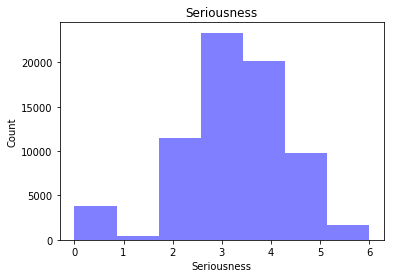

In [34]:
data = df['seriousness']
num_bins = 7
# the histogram of the data
n, bins, patches = plt.hist(data, num_bins, facecolor='blue', alpha=0.5)
 
plt.plot()
plt.xlabel('Seriousness')
plt.xticks(np.arange(0, 7, step=1))
plt.ylabel('Count')
plt.title('Seriousness')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15) 
plt.show()

# Drop duplicates

Subsequent cell drops duplicate booking IDs so count = individual bookings, not charges. Mask any variables that we want to analyze further.

In [35]:
df_all = df.copy()
df = df.drop_duplicates(subset=['booking_id'])
assert len(df) == len(set(df_all['booking_id']))

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29312 entries, 0 to 70802
Data columns (total 52 columns):
booking_id                  29312 non-null object
booking_dt                  29312 non-null datetime64[ns]
release_dt                  29312 non-null datetime64[ns]
booking_charge_desc         29312 non-null object
booking_charge_txt          1836 non-null object
charge_release_dt           29312 non-null datetime64[ns]
title_txt                   29312 non-null object
cause_num                   21612 non-null object
jurisdiction_cd             29312 non-null object
release_disposition_desc    29312 non-null object
post_flg                    29312 non-null object
gender_desc                 29312 non-null object
race_desc                   29312 non-null object
hash_id                     29312 non-null object
amer_indian_alaskan         29312 non-null int64
asian_pacific_island        29312 non-null int64
black                       29312 non-null int64
hispanic             

In [37]:
df.set_index('booking_id',inplace=True)

# Final release disp

In [38]:
(df[df['imm_hold'] == 1]['final_release_disp'].value_counts() / sum(df['imm_hold'] == 1) * 100).head()

Immigration   28.72
WSI Chain     18.09
Mini-Chain     8.51
Dismissed      6.91
Court Order    5.32
Name: final_release_disp, dtype: float64

In [39]:
(df[df['imm_hold'] == 1]['final_release_disp'].value_counts()).head()

Immigration    54
WSI Chain      34
Mini-Chain     16
Dismissed      13
Court Order    10
Name: final_release_disp, dtype: int64

In [40]:
(df[df['imm_hold'] == 0]['final_release_disp'].value_counts() / sum(df['imm_hold'] == 0) * 100).head()

Bail Bond     17.39
PR            11.63
Time Served   10.21
WSI Chain      7.75
Mini-Chain     6.61
Name: final_release_disp, dtype: float64

## General measures

### Date ranges

In [41]:
earliest_booking = df.booking_dt.min()
latest_booking = df.booking_dt.max()
earliest_release = df.release_dt.min()
latest_release = df.release_dt.max()
print(f'Booking dates:\n{df.booking_dt.describe()}\n\nRelease dates:\n{df.release_dt.describe()}')

Booking dates:
count                   29312
unique                  29173
top       2018-05-09 14:51:00
freq                        2
first     2013-06-21 18:42:00
last      2018-07-31 15:38:00
Name: booking_dt, dtype: object

Release dates:
count                   29312
unique                  15220
top       2018-03-29 09:00:00
freq                       26
first     2016-10-01 01:00:00
last      2018-07-31 21:55:00
Name: release_dt, dtype: object


### Demographics

Demographics as reported by Pierce County corrections:

In [42]:
race_count = df['race_desc'].value_counts()
race_percent = race_count/len(df)*100
print(f'Count of race categories:\n{race_count}\n')
print(f'Race categories as percent of total jail population:\n{race_percent}')

Count of race categories:
white                   16918
black                    7110
hispanic                 2540
asian/pacific island     1790
amer indian/alaskan       892
unknown                    62
Name: race_desc, dtype: int64

Race categories as percent of total jail population:
white                  57.72
black                  24.26
hispanic                8.67
asian/pacific island    6.11
amer indian/alaskan     3.04
unknown                 0.21
Name: race_desc, dtype: float64


Checking for discrepancies in race counts for individuals booked less than 72, 24 hours:

In [43]:
less_than_72_hrs = df['time_detained'] > 3
less_than_24_hrs = df['time_detained'] > 1

In [44]:
less_than_72_hrs_percent = df[less_than_72_hrs]['race_desc'].value_counts()/len(df[less_than_72_hrs])*100
less_than_24_hrs_percent = df[less_than_24_hrs]['race_desc'].value_counts()/len(df[less_than_24_hrs])*100
print(f'Race percents for inmates detained less than 72 hrs:\n{less_than_72_hrs_percent}')
print()
print(f'Race percents for inmates detained less than 24 hrs:\n{less_than_24_hrs_percent}')

Race percents for inmates detained less than 72 hrs:
white                  56.95
black                  25.70
hispanic                8.11
asian/pacific island    5.56
amer indian/alaskan     3.53
unknown                 0.15
Name: race_desc, dtype: float64

Race percents for inmates detained less than 24 hrs:
white                  57.01
black                  25.23
hispanic                8.34
asian/pacific island    6.05
amer indian/alaskan     3.18
unknown                 0.19
Name: race_desc, dtype: float64


Demographics as predicted by `ethnicolr` module:

In [45]:
# value_count = df['race_ethnicolr'].value_counts()
# print(f'Count of predicted race categories:\n{value_count}\n')
# print(f'Predicted race categories as percent of total jail population:\n{value_count/len(df)*100}')

### Gender:

In [46]:
value_count = df['gender_desc'].value_counts()
print(f'Count of gender categories:\n{value_count}\n')
print(f'Gender categories as percent of total jail population:\n{value_count/len(df)*100}')

Count of gender categories:
male      22029
female     7283
Name: gender_desc, dtype: int64

Gender categories as percent of total jail population:
male     75.15
female   24.85
Name: gender_desc, dtype: float64


## Charges and seriousness:

In [47]:
df['max_charge_desc'].value_counts().head(10)

UPCS                         2744
DWI                          2363
ASSAULT 4 /DV                2000
CRIM ASLT /DV                1605
POSSESS STOLEN VEHICLE       1437
BURGLARY 2                    880
VIO NC ORD /DV                652
DUI WITH PRIOR CONVICTION     637
DWLS/DWLR                     605
ASLT 2 -DV                    581
Name: max_charge_desc, dtype: int64

In [48]:
df['max_charge_type'].value_counts().head(10)

public_order    9426
violent         7935
property        7836
drug            3606
sex              509
Name: max_charge_type, dtype: int64

In [49]:
df['max_seriousness'].describe()

count   29312.00
mean        3.98
std         0.96
min         0.00
25%         3.00
50%         4.00
75%         5.00
max         6.00
Name: max_seriousness, dtype: float64

In [50]:
df[['felony', 'misdemeanor']].describe()

,felony,misdemeanor
count,29312.00,29312.00
mean,0.69,0.31
std,0.46,0.46
min,0.00,0.00
25%,0.00,0.00
50%,1.00,0.00
75%,1.00,1.00
max,1.00,1.00


In [51]:
misdemeanor_mask = (df['max_seriousness'] >= 2) & (df['max_seriousness'] <=3 )

In [52]:
df[misdemeanor_mask]

,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,cause_num,jurisdiction_cd,release_disposition_desc,post_flg,...,property,public_order,sex,violent,felony,misdemeanor,total_fine,paid_bail,at_least_one_other_type,all_holds
booking_id,,,,,,,,,,,,,,,,,,,,,
000de109bb900f8d706aa8a0b627255378681409,2017-10-24 10:59:00,2017-10-25 13:10:00,INTIM W/WPN /DV,NaN,2017-10-25 15:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",NaN,TACM,NCF Final,N,...,0,0,0,1,0,1,0.00,False,0,0
00144444b16b26192285bd27ef34cbc514717db4,2017-02-03 09:28:00,2017-02-21 22:30:00,THEFT 3,NaN,2017-02-21 22:30:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",C00070495,PUYM,Police Department,N,...,1,0,0,0,0,1,0.00,False,0,0
0019ab3ba5942e4a1dbad4ac8866b41820361c7e,2018-03-03 10:12:00,2018-03-13 12:15:00,VIO NC ORD /DV,NaN,2018-03-13 18:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",8ZC000780,PD1,Credit for Time Served,N,...,0,1,0,0,0,1,0.00,False,0,0
001e2637a030b9f9aad0c776949c29a8cfe6e900,2017-07-21 01:20:00,2017-07-24 20:20:00,VIOL OF SENTENCE/NCO DV,NaN,2017-07-24 21:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",D00043473,TACM,Bail Bond,N,...,0,1,0,0,0,1,6000.00,True,0,0
00200ba6ae3fd65cf91de3fcb8fadb8c06a8a4df,2018-06-06 03:03:00,2018-06-06 11:00:00,DWI,NaN,2018-06-06 11:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",1Z0015972,KINS,Mini-Chain,N,...,0,1,0,0,0,1,0.00,False,0,0
00256f18f629fd354ee29d137336ec5c368326ac,2017-08-01 13:04:00,2017-08-21 05:00:00,VIO REST OR /DV,NaN,2017-08-21 05:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",D00041730,TACM,Time Served,N,...,0,1,0,0,0,1,0.00,False,0,0
0028a87cc5440c7f8e397399d4235d6d88a9067f,2016-11-08 10:25:00,2016-11-09 14:25:00,DWI,NaN,2016-11-09 18:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",4ZC002947,PD1,Bail Bond,N,...,0,1,0,0,0,1,1000.00,True,0,0
002d2d1a5e8e913fc7f38ff87a86fae63a8fd661,2018-07-14 01:03:00,2018-07-16 12:20:00,VIO PROT OR /DV,NaN,2018-07-16 15:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",NaN,TACM,NCF Final,N,...,0,1,0,0,0,1,0.00,False,0,0
00339ca6f60362a3a47eb55836a407d993842001,2017-05-01 08:37:00,2017-05-01 18:55:00,INTERF PO,NaN,2017-05-01 22:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",NaN,TACM,Bail Bond,N,...,0,1,0,0,0,1,1000.00,True,0,0


Distribution of seriousness:

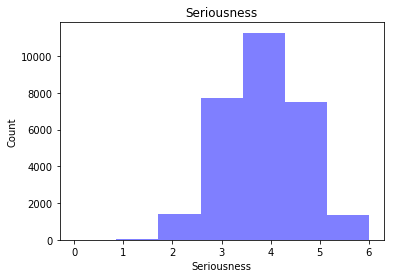

In [53]:
data = df['max_seriousness']
num_bins = 7
# the histogram of the data
n, bins, patches = plt.hist(data, num_bins, facecolor='blue', alpha=0.5)
 
plt.plot()
plt.xlabel('Seriousness')
plt.xticks(np.arange(0, 7, step=1))
plt.ylabel('Count')
plt.title('Seriousness')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15) 
plt.show()

In [54]:
# data = df[hold_mask]['max_seriousness']
# num_bins = 7
# # the histogram of the data
# n, bins, patches = plt.hist(data, num_bins, facecolor='blue', alpha=0.5)
 
# plt.plot()
# plt.xlabel('Seriousness')
# plt.xticks(np.arange(0, 7, step=1))
# plt.ylabel('Count')
# plt.title('Seriousness')
 
# # Tweak spacing to prevent clipping of ylabel
# plt.subplots_adjust(left=0.15) 
# plt.show()

Distribution of charges: raw versus top counted to 10 max

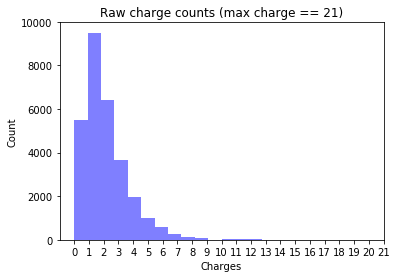

In [55]:
data = df['charge_count']
num_bins = 22
# the histogram of the data
n, bins, patches = plt.hist(data, num_bins, facecolor='blue', alpha=0.5)
 
plt.plot()
plt.xlabel('Charges')
plt.xticks(np.arange(0, 22, step=1))
plt.ylabel('Count')
plt.title('Raw charge counts (max charge == 21)')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15) 
plt.show()

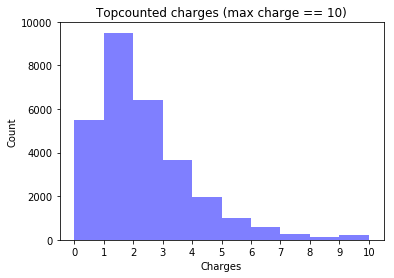

In [56]:
data = df['charge_topcount']
num_bins = 10
# the histogram of the data
n, bins, patches = plt.hist(data, num_bins, facecolor='blue', alpha=0.5)
 
# add a 'best fit' line
plt.plot()
plt.xlabel('Charges')
plt.xticks(np.arange(0, 11, step=1))
plt.ylabel('Count')
plt.title('Topcounted charges (max charge == 10)')
 
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [57]:
df[df['max_seriousness'] == 0]['max_charge_type']

booking_id
30fac058761ea9ea0130f9c5326e457277c31ac7    public_order
550b093f18a1a03e82b96163444fa887930b0581    public_order
556926e82a87d0b998baa873fa941566950a2828    public_order
799fd24af9a7d8bc356abb354e2d01d006cd4dc0    public_order
993b1c5ad58aac4025ea390d79c16e387d8c2979    public_order
dd567ac9c6be7bd915d7ff06782092e36ed87fe7    public_order
e66f41c5bd6d5e2d961a53041f7e07670d23db91    public_order
ea9162683273da0dd020ba5a56f284c33f874435    public_order
ed2d25027c77ad32ef6c7e61c8ccfcae35ee1b1d    public_order
Name: max_charge_type, dtype: object

In [58]:
df[df['max_seriousness'] == 0]['max_charge_desc']

booking_id
30fac058761ea9ea0130f9c5326e457277c31ac7            BAIL JUMP
550b093f18a1a03e82b96163444fa887930b0581            BAIL JUMP
556926e82a87d0b998baa873fa941566950a2828            BAIL JUMP
799fd24af9a7d8bc356abb354e2d01d006cd4dc0            BAIL JUMP
993b1c5ad58aac4025ea390d79c16e387d8c2979            BAIL JUMP
dd567ac9c6be7bd915d7ff06782092e36ed87fe7            BAIL JUMP
e66f41c5bd6d5e2d961a53041f7e07670d23db91    COMM LIC REQUIRED
ea9162683273da0dd020ba5a56f284c33f874435    PROB VIOL (PROST)
ed2d25027c77ad32ef6c7e61c8ccfcae35ee1b1d            BAIL JUMP
Name: max_charge_desc, dtype: object

## Charge count == 0

In [59]:
zero_charges = df['charge_count'] == 0

In [60]:
df[zero_charges].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5512 entries, 0007a46fa0c866514bb6ee2970e79f34eb2a31b1 to fffaf492ddcc8c7a2d7fa6cf22e8b9540dce8f7b
Data columns (total 51 columns):
booking_dt                  5512 non-null datetime64[ns]
release_dt                  5512 non-null datetime64[ns]
booking_charge_desc         5512 non-null object
booking_charge_txt          213 non-null object
charge_release_dt           5512 non-null datetime64[ns]
title_txt                   5512 non-null object
cause_num                   0 non-null object
jurisdiction_cd             5512 non-null object
release_disposition_desc    5512 non-null object
post_flg                    5512 non-null object
gender_desc                 5512 non-null object
race_desc                   5512 non-null object
hash_id                     5512 non-null object
amer_indian_alaskan         5512 non-null int64
asian_pacific_island        5512 non-null int64
black                       5512 non-null int64
hispanic              

In [61]:
sum(df[zero_charges]['imm_hold'])

24

In [62]:
df[zero_charges]['total_fine'].describe()

count     5512.00
mean       835.90
std       5746.97
min          0.00
25%          0.00
50%          0.00
75%       1000.00
max     200000.00
Name: total_fine, dtype: float64

In [63]:
df[~zero_charges]['total_fine'].describe()

count    23800.00
mean      2022.89
std      10863.44
min          0.00
25%          0.00
50%          0.00
75%          0.00
max     500000.00
Name: total_fine, dtype: float64

In [64]:
df[zero_charges]['max_charge_desc'].value_counts().head(10)

ASSAULT 4 /DV                766
DWI                          723
CRIM ASLT /DV                552
UPCS                         327
DUI WITH PRIOR CONVICTION    241
POSSESS STOLEN VEHICLE       233
ASLT 2 -DV                   144
CRIM TRESP                   138
VIO NC ORD /DV               119
DWLS/DWLR                    104
Name: max_charge_desc, dtype: int64

In [65]:
# df = df[~zero_charges]

## Statistics on inmates with immigration holds

In [66]:
print(f'Inmates with immigration hold: {sum(df.imm_hold)}')
print(f'Inmates released to immigration: {sum(df.release_to_imm)}')

Inmates with immigration hold: 188
Inmates released to immigration: 120


In [67]:
sum(df.imm_hold)/len(df)*100

0.6413755458515285

In [68]:
hold_mask = df['imm_hold'] == 1
all_hold_mask = df['all_holds'] == 1

In [69]:
print(df[hold_mask]['gender_desc'].value_counts() / len(df[hold_mask]) * 100)
print('')
print(df[~hold_mask]['gender_desc'].value_counts() / len(df[~hold_mask]) * 100)

male     97.87
female    2.13
Name: gender_desc, dtype: float64

male     75.01
female   24.99
Name: gender_desc, dtype: float64


In [70]:
print(df[hold_mask]['race_desc'].value_counts() / len(df[hold_mask]) * 100)
print('')
print(df[~hold_mask]['race_desc'].value_counts() / len(df[~hold_mask]) * 100)

hispanic               80.85
asian/pacific island    9.57
white                   4.79
black                   4.26
unknown                 0.53
Name: race_desc, dtype: float64

white                  58.06
black                  24.39
hispanic                8.20
asian/pacific island    6.08
amer indian/alaskan     3.06
unknown                 0.21
Name: race_desc, dtype: float64


In [71]:
race_foreign = df.groupby('race_desc')['born_in_us'].count() - df.groupby('race_desc')['born_in_us'].sum()

In [72]:
race_foreign / df.groupby('race_desc')['born_in_us'].count() * 100

race_desc
amer indian/alaskan     8.86
asian/pacific island   28.16
black                   7.54
hispanic               29.37
unknown                25.81
white                   5.46
Name: born_in_us, dtype: float64

In [73]:
aia = df[df['race_desc'] == 'amer indian/alaskan']
hispanic = df[df['race_desc'] == 'hispanic']
api = df[df['race_desc'] == 'asian/pacific island']

In [74]:
aia[aia['born_in_us'] == False]['country_of_birth'].value_counts(dropna=False)

UNKNOWN         50
NaN             16
CANADA           8
SOUTH AFRICA     2
GERMANY          2
INDIA            1
Name: country_of_birth, dtype: int64

In [75]:
hispanic[hispanic['born_in_us'] == False]['country_of_birth'].value_counts(dropna=False).head(10)

MEXICO         497
NaN             48
UNKNOWN         45
HONDURAS        22
GUATEMALA       21
EL SALVADOR     20
GERMANY         12
COLOMBIA        10
CUBA             9
PANAMA           8
Name: country_of_birth, dtype: int64

In [76]:
api[api['born_in_us'] == False]['country_of_birth'].value_counts(dropna=False).head(10)

SOUTH KOREA                       108
PHILIPPINES                        68
SOCIALIST REPUBLIC OF VIETNAM      55
THAILAND                           47
CAMBODIA                           41
NaN                                33
PEOPLES REPUBLIC OF CHINA          32
UNKNOWN                            29
FEDERATED STATES OF MICRONESIA     16
LAOS                               12
Name: country_of_birth, dtype: int64

In [77]:
race_ice_holds = df.groupby('race_desc')['imm_hold'].sum()
race_all_holds = df.groupby('race_desc')['all_holds'].sum()
race_release_imm = df.groupby('race_desc')['release_to_imm'].sum()
race_foreign = df.groupby('race_desc')['born_in_us'].count() - df.groupby('race_desc')['born_in_us'].sum()
n = df['race_desc'].value_counts()
race_hold_df = pd.DataFrame([n, race_ice_holds, race_all_holds, race_release_imm, race_foreign]).T
race_hold_df.columns = ['n', 'imm_hold', 'all_holds', 'release_to_imm', 'race_foreign']
race_hold_df['ice_hold_percent'] = race_hold_df['imm_hold']/race_hold_df['n'] * 100
race_hold_df['all_hold_percent'] = race_hold_df['all_holds']/race_hold_df['n'] * 100
race_hold_df['release_imm_percent'] = race_hold_df['release_to_imm']/race_hold_df['n'] * 100
race_hold_df['race_foreign_percent'] = race_foreign / df.groupby('race_desc')['born_in_us'].count() * 100
race_hold_df

,n,imm_hold,all_holds,release_to_imm,race_foreign,ice_hold_percent,all_hold_percent,release_imm_percent,race_foreign_percent
white,16918.00,9.00,483.00,5.00,923.00,0.05,2.85,0.03,5.46
black,7110.00,8.00,267.00,7.00,536.00,0.11,3.76,0.10,7.54
hispanic,2540.00,152.00,221.00,99.00,746.00,5.98,8.70,3.90,29.37
asian/pacific island,1790.00,18.00,70.00,9.00,504.00,1.01,3.91,0.50,28.16
amer indian/alaskan,892.00,0.00,21.00,0.00,79.00,0.00,2.35,0.00,8.86
unknown,62.00,1.00,3.00,0.00,16.00,1.61,4.84,0.00,25.81


In [102]:
pd.crosstab(df['born_in_us'], df['imm_hold'])

imm_hold,0,1
born_in_us,,
False,2621,183
True,26503,5


In [94]:
pd.crosstab(df['race_desc'], [df['born_in_us'], df['imm_hold']], normalize='index')

born_in_us           False      True      
imm_hold                 0    1     0    1
race_desc                                 
amer indian/alaskan   0.09 0.00  0.91 0.00
asian/pacific island  0.27 0.01  0.72 0.00
black                 0.07 0.00  0.92 0.00
hispanic              0.23 0.06  0.71 0.00
unknown               0.24 0.02  0.74 0.00
white                 0.05 0.00  0.95 0.00

In [96]:
scipystats.chi2_contingency(pd.crosstab(df['race_desc'], [df['born_in_us'], df['imm_hold']]))

(3025.5478197255006,
 0.0,
 15,
 array([[7.97602347e+01, 5.56891376e+00, 8.06518695e+02, 1.52156114e-01],
        [1.60056973e+02, 1.11752866e+01, 1.61846240e+03, 3.05335699e-01],
        [6.35757028e+02, 4.43889874e+01, 6.42864117e+03, 1.21281386e+00],
        [2.27119951e+02, 1.58576692e+01, 2.29658911e+03, 4.33269651e-01],
        [5.54387282e+00, 3.87076965e-01, 5.60584743e+01, 1.05758734e-02],
        [1.51276194e+03, 1.05622066e+02, 1.52967301e+04, 2.88584880e+00]]))

In [497]:
race_ice_holds = df.groupby('race_desc')['imm_hold'].sum()
n = df['race_desc'].value_counts()
simple_race_hold_df = pd.DataFrame([n, race_ice_holds]).T
simple_race_hold_df.columns = ['n', 'imm_hold']
simple_race_hold_df['ice_hold_percent'] = simple_race_hold_df['imm_hold']/simple_race_hold_df['n'] * 100
simple_race_hold_df

,n,imm_hold,ice_hold_percent
white,16919,9,0.05
black,7110,8,0.11
hispanic,2540,152,5.98
asian/pacific island,1790,18,1.01
amer indian/alaskan,892,0,0.00
unknown,62,1,1.61


In [498]:
# race_ice_holds = df.groupby('race_ethnicolr')['imm_hold'].sum()
# race_all_holds = df.groupby('race_ethnicolr')['all_holds'].sum()
# n = df['race_ethnicolr'].value_counts()
# race_hold_df = pd.DataFrame([n, race_ice_holds, race_all_holds]).T
# race_hold_df.columns = ['n', 'imm_hold', 'all_holds']
# race_hold_df['imm_hold_percent'] = race_hold_df['imm_hold']/race_hold_df['n'] * 100
# race_hold_df['all_hold_percent'] = race_hold_df['all_holds']/race_hold_df['n'] * 100
# race_hold_df

In [499]:
sns.set(style="whitegrid", color_codes=True)

In [500]:
race_order = ['white', 'black', 'amer indian/alaskan', 'hispanic', 'asian/pacific island', 'unknown']

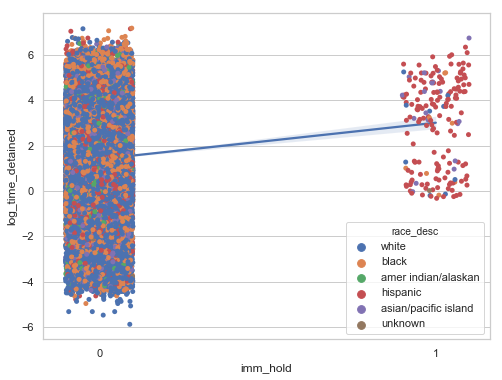

In [501]:
sns.stripplot(x="imm_hold",
              y="log_time_detained",
              hue="race_desc",
              hue_order=race_order,
              marker='o',
              data=df,
              jitter=True);
sns.regplot(x="imm_hold", y="log_time_detained", truncate=True, marker='', data=df);

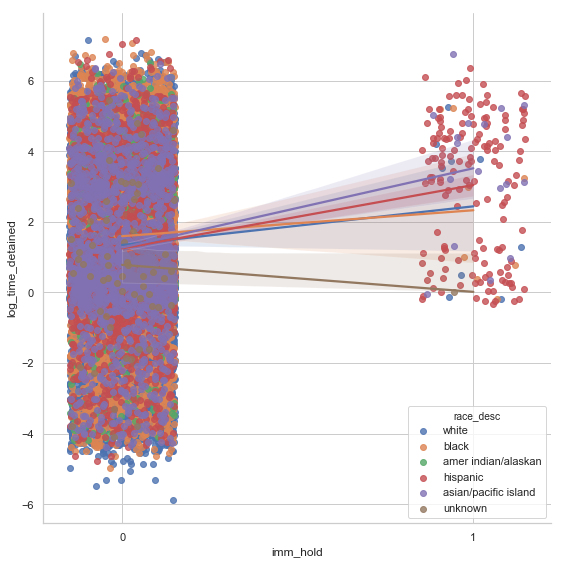

In [502]:
plt = sns.lmplot(x="imm_hold",
                 y="log_time_detained",
                 hue='race_desc',
                 hue_order=race_order,
                 truncate=True,
                 markers='o',
                 legend_out=False,
                 x_jitter=0.15,
                 data=df,
                 height=8,
                 aspect=1)
plt.set(xticks=[0, 1])
plt.despine();

In [503]:
# ethnicolr_order = ['nh_white', 'nh_black', 'hispanic', 'asian']
# plt = sns.lmplot(x="imm_hold",
#                  y="log_time_detained",
#                  hue='race_ethnicolr',
#                  hue_order=ethnicolr_order,
#                  truncate=True,
#                  markers='o',
#                  legend_out=False,
#                  x_jitter=0.15,
#                  data=df,
#                  height=8,
#                  aspect=1);
# plt.set(xticks=[0, 1])
# plt.despine();

In [504]:
hold = df['imm_hold'] == 1
no_hold = df['imm_hold'] == 0
release_to_imm = df['release_to_imm'] == 1
no_release_to_imm = df['release_to_imm'] == 0

In [505]:
df[hold]['max_charge_type'].value_counts()

public_order    56
violent         43
drug            39
property        34
sex             16
Name: max_charge_type, dtype: int64

In [506]:
df[hold]['max_charge_desc'].value_counts().head()

DWI                          24
UPCS                         18
UPCS W INTENT                14
POSSESS STOLEN VEHICLE       11
DUI WITH PRIOR CONVICTION    11
Name: max_charge_desc, dtype: int64

# Correlation of felony with hold category

In [507]:
sum(df['misdemeanor'])

9146

In [508]:
sum(df['felony'])

20117

In [509]:
pd.crosstab(df.imm_hold, df.max_seriousness, normalize='index') * 100

max_seriousness,0.0,1.0,2.0,3.0,4.0,5.0,6.0
imm_hold,,,,,,,
0,0.03,0.13,4.86,26.41,38.50,25.53,4.53
1,0.00,0.53,2.66,18.09,34.57,33.51,10.64


In [510]:
pd.crosstab(df.felony, df.imm_hold)

imm_hold,0,1
felony,,
0,9156,40
1,19969,148


In [511]:
pd.crosstab(df.felony, df.imm_hold, margins=True, normalize='columns') * 100

imm_hold,0,1,All
felony,,,
0,31.44,21.28,31.37
1,68.56,78.72,68.63


Significant relationship between felony and presence of immigration hold:

In [512]:
scipystats.chi2_contingency(pd.crosstab(df.felony, df.imm_hold))

(8.490754380282445,
 0.0035695576807330616,
 1,
 array([[ 9137.02111691,    58.97888309],
        [19987.97888309,   129.02111691]]))

Insignificant relationship between felony and all holds:

In [513]:
scipystats.chi2_contingency(pd.crosstab(df.felony, df.all_holds))

(9.955365812594813,
 0.0016038125515229896,
 1,
 array([[ 8861.57718418,   334.42281582],
        [19385.42281582,   731.57718418]]))

Significant relationship between seriousness and presence of immigration hold:

In [514]:
scipystats.chi2_contingency(pd.crosstab(df.max_seriousness, df.imm_hold))

(29.641341376365645,
 4.598497669417539e-05,
 6,
 array([[9.93586463e+00, 6.41353666e-02],
        [3.97434585e+01, 2.56541466e-01],
        [1.41089278e+03, 9.10722205e+00],
        [7.67644902e+03, 4.95509842e+01],
        [1.12056681e+04, 7.23318664e+01],
        [7.45090489e+03, 4.80951114e+01],
        [1.33140586e+03, 8.59413912e+00]]))

Insignificant relationship between felony and race:

In [515]:
pd.crosstab(df.race_desc, df.felony, margins=True, normalize='index') * 100

felony,0,1
race_desc,,
amer indian/alaskan,34.53,65.47
asian/pacific island,32.07,67.93
black,30.70,69.30
hispanic,31.46,68.54
unknown,25.81,74.19
white,31.42,68.58
All,31.37,68.63


In [516]:
scipystats.chi2_contingency(pd.crosstab(df.race_desc, df.felony))

(6.927057816833902,
 0.2261218830901794,
 5,
 array([[  279.83597721,   612.16402279],
        [  561.5542592 ,  1228.4457408 ],
        [ 2230.53116365,  4879.46883635],
        [  796.84235663,  1743.15764337],
        [   19.45048272,    42.54951728],
        [ 5307.78576058, 11611.21423942]]))

Very significant relationship between immigration hold and race:

In [517]:
pd.crosstab(df.race_desc, df.imm_hold)

imm_hold,0,1
race_desc,,
amer indian/alaskan,892,0
asian/pacific island,1772,18
black,7102,8
hispanic,2388,152
unknown,61,1
white,16910,9


In [518]:
scipystats.chi2_contingency(pd.crosstab(df.race_desc, df.imm_hold))

(1271.3008552959466,
 1.053762180267414e-272,
 5,
 array([[8.86279125e+02, 5.72087470e+00],
        [1.77851977e+03, 1.14802306e+01],
        [7.06439975e+03, 4.56002456e+01],
        [2.52370962e+03, 1.62903831e+01],
        [6.16023607e+01, 3.97639273e-01],
        [1.68104894e+04, 1.08510627e+02]]))

In [148]:
scipystats.chi2_contingency(pd.crosstab(df.race_desc, df.born_in_us))

(2250.3716159231217, 0.0, 5, array([[8.53262375e+01, 8.06673762e+02],
        [1.71226418e+02, 1.61877358e+03],
        [6.80122812e+02, 6.42987719e+03],
        [2.42969331e+02, 2.29703067e+03],
        [5.93074745e+00, 5.60692526e+01],
        [1.61842445e+03, 1.53005755e+04]]))

In [149]:
scipystats.chi2_contingency(pd.crosstab(df.born_in_us, df.imm_hold))

(1674.9594197842925, 0.0, 1, array([[2.78601644e+03, 1.79835568e+01],
        [2.63389836e+04, 1.70016443e+02]]))

In [519]:
# pd.crosstab(df.race_ethnicolr, df.imm_hold)

In [520]:
pd.crosstab(df.type, df.imm_hold, margins=True, normalize='columns') * 100

imm_hold,0,1,All
type,,,
drug,10.48,11.17,10.48
other,4.10,35.64,4.30
property,24.02,10.64,23.94
public_order,38.70,27.13,38.62
sex,1.61,5.85,1.63
violent,21.10,9.57,21.02


In [521]:
scipystats.chi2_contingency(pd.crosstab(df.type, df.imm_hold))

(484.83758379418646,
 1.4953886103791076e-102,
 5,
 array([[3.05329120e+03, 1.97087981e+01],
        [1.25291253e+03, 8.08746972e+00],
        [6.97199621e+03, 4.50037867e+01],
        [1.12483924e+04, 7.26076485e+01],
        [4.75927916e+02, 3.07208406e+00],
        [6.12247979e+03, 3.95202129e+01]]))

In [522]:
# scipystats.chi2_contingency(pd.crosstab(df.race_ethnicolr, df.imm_hold))

Significant relationship between race and all holds:

In [523]:
scipystats.chi2_contingency(pd.crosstab(df.race_desc, df.all_holds))

(220.0618046943054,
 1.441215909246028e-45,
 5,
 array([[8.59561423e+02, 3.24385767e+01],
        [1.72490465e+03, 6.50953502e+01],
        [6.85143691e+03, 2.58563095e+02],
        [2.44763006e+03, 9.23699383e+01],
        [5.97453007e+01, 2.25469928e+00],
        [1.63037217e+04, 6.15278341e+02]]))

In [524]:
print(f'Race categories as percent of ICE holds')
print(f"{df[hold].groupby('race_desc')['race_desc'].count() / len(df[hold]) * 100}\n")
print(f'n = {len(hold)}')
print('\n')
print(f'Race categories as percent of all inmates')
print(f"{df.groupby('race_desc')['race_desc'].count() / len(df) * 100}\n")
print(f'n = {len(df)}')

Race categories as percent of ICE holds
race_desc
asian/pacific island    9.57
black                   4.26
hispanic               80.85
unknown                 0.53
white                   4.79
Name: race_desc, dtype: float64

n = 29313


Race categories as percent of all inmates
race_desc
amer indian/alaskan     3.04
asian/pacific island    6.11
black                  24.26
hispanic                8.67
unknown                 0.21
white                  57.72
Name: race_desc, dtype: float64

n = 29313


In [525]:
# print(f'Race categories as percent of ICE holds')
# print(f"{df[hold].groupby('race_ethnicolr')['race_ethnicolr'].count() / len(df[hold]) * 100}\n")
# print(f'n = {len(hold)}')
# print('\n')
# print(f'Race categories as percent of all inmates')
# print(f"{df.groupby('race_ethnicolr')['race_ethnicolr'].count() / len(df) * 100}\n")
# print(f'n = {len(df)}')

In [526]:
# Race breakdown of cases released to immigration:
print(df.groupby('race_desc')['release_to_imm'].sum())

race_desc
amer indian/alaskan      0
asian/pacific island     9
black                    7
hispanic                99
unknown                  0
white                    5
Name: release_to_imm, dtype: int64


In [527]:
# Percent of bookings with immigration holds released to immigration
print(sum(df[hold]['release_to_imm'] == 1) / len(df[hold]) * 100)
print('\n')
print(f'n = {len(df[hold])}')

63.297872340425535


n = 188


In [528]:
hispanic = df[df.hispanic == 1]

In [529]:
hispanic_with_hold = hispanic[hispanic.imm_hold == 1]
hispanic_release_to_imm = hispanic[hispanic.release_to_imm == 1]

Percents of hispanics with immigration holds; released to immigration:

In [530]:
print(len(hispanic_with_hold) / len(hispanic) * 100)
print(len(hispanic_release_to_imm) / len(hispanic) * 100)
print('\n')
print(f'n={len(hispanic)}')

5.984251968503937
3.8976377952755907


n=2540


In [531]:
df.groupby('imm_hold')['felony'].sum() / df.groupby('imm_hold')['felony'].count() * 100

imm_hold
0   68.56
1   78.72
Name: felony, dtype: float64

In [532]:
df.groupby('imm_hold')['max_seriousness'].mean()

imm_hold
0   3.98
1   4.30
Name: max_seriousness, dtype: float64

In [533]:
df.groupby('imm_hold')['charge_topcount'].mean()

imm_hold
0   1.88
1   2.06
Name: charge_topcount, dtype: float64

In [534]:
df['imm_hold_text'] = df['imm_hold'].replace({0: 'No detainer', 1: 'Detainer'})

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [535]:
df['felony_misdemeanor'] = df['max_seriousness'].replace({6: 'Felony',
                              5: 'Felony',
                              4: 'Felony',
                              3: 'Misdemeanor',
                              2: 'Misdemeanor',
                              1: None,
                              0: None})

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [536]:
table = pd.pivot_table(df, values='time_detained', index='felony_misdemeanor',
                       columns='imm_hold_text', aggfunc=np.mean)

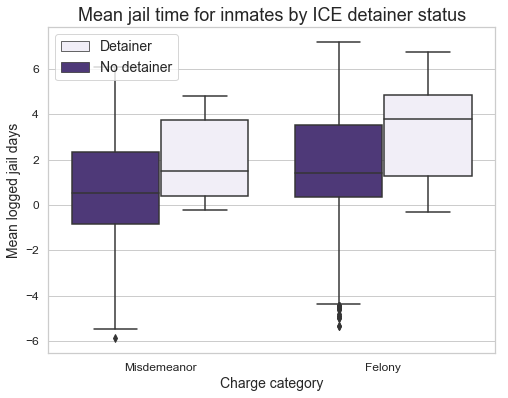

In [537]:
def boxplot(data):
    
    # Create the bar plot
    ax = sns.boxplot(
        x='felony_misdemeanor',
        y='log_time_detained',
        hue='imm_hold_text',
        hue_order=['Detainer', 'No detainer'],
        color='#4B2E83',
        data=df)
    
    ax.legend(loc=2, fontsize=14)
    ax.set_title("Mean jail time for inmates by ICE detainer status", fontsize=18)
    ax.set_ylabel('Mean logged jail days', fontsize=14)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlabel('Charge category', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.invert_xaxis()
    # Return the figure object and axis
    return plt, ax

boxplot(table);

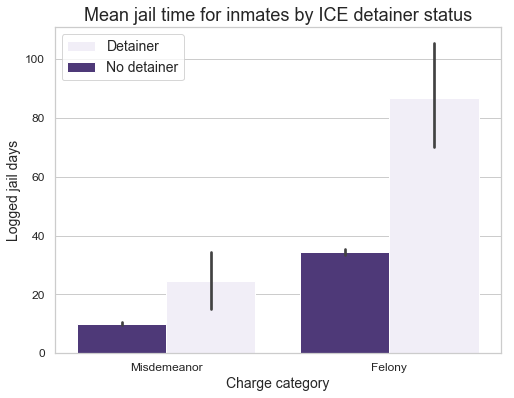

In [538]:
def barplot(data):
    
    # Create the bar plot
    ax = sns.barplot(
        x='felony_misdemeanor',
        y='time_detained',
        hue='imm_hold_text',
        hue_order=['Detainer', 'No detainer'],
        color='#4B2E83',
        data=df)
    
    ax.legend(loc=2, fontsize=14)
    ax.set_title("Mean jail time for inmates by ICE detainer status", fontsize=18)
    ax.set_ylabel('Logged jail days', fontsize=14)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlabel('Charge category', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.invert_xaxis()
    # Return the figure object and axis
    return plt, ax

barplot(table);

In [539]:
felony = df['felony_misdemeanor'] == 'felony'

In [540]:
hold = df['imm_hold_text'] == 'Detainer'

In [541]:
no_hold_table = df.loc[~hold].groupby('felony_misdemeanor')['time_detained'].describe()
no_hold_table.reset_index(inplace=True)
no_hold_table['detainer_status'] = 'No detainer'
no_hold_table.set_index('detainer_status')

,felony_misdemeanor,count,mean,std,min,25%,50%,75%,max
detainer_status,,,,,,,,,
No detainer,Felony,19969.00,34.55,74.95,0.00,1.41,4.00,33.18,1314.55
No detainer,Misdemeanor,9107.00,10.08,23.35,0.00,0.43,1.66,10.45,431.80


In [542]:
hold_table = df.loc[hold].groupby('felony_misdemeanor')['time_detained'].describe()
hold_table.reset_index(inplace=True)
hold_table['detainer_status'] = 'Detainer'
hold_table.set_index('detainer_status')

,felony_misdemeanor,count,mean,std,min,25%,50%,75%,max
detainer_status,,,,,,,,,
Detainer,Felony,148.00,86.87,118.17,0.72,3.55,44.55,129.08,849.24
Detainer,Misdemeanor,39.00,24.49,32.66,0.79,1.48,4.46,42.00,120.30


In [543]:
verbose_table = pd.concat([no_hold_table, hold_table])

In [544]:
verbose_table.set_index('detainer_status',inplace=True)
# verbose_table.to_csv('../output/verbose_felony_misdemeanor.csv')

In [545]:
table['% increase'] = table['Detainer'] / table['No detainer'] * 100

In [546]:
table

imm_hold_text,Detainer,No detainer,% increase
felony_misdemeanor,,,
Felony,86.87,34.55,251.47
Misdemeanor,24.49,10.08,243.03


In [547]:
# table.to_csv('../output/felony_misdemeanor.csv')

In [548]:
ttest = scipystats.ttest_ind(df[hold]['time_detained'], df[~hold]['time_detained'])

In [549]:
ttest

Ttest_indResult(statistic=9.860903681963814, pvalue=6.675606109161849e-23)

In [550]:
ttest.pvalue

6.675606109161849e-23

In [551]:
df[hold]['time_detained'].describe()

count   188.00
mean     73.62
std     108.85
min       0.72
25%       2.65
50%      34.77
75%     103.30
max     849.24
Name: time_detained, dtype: float64

In [552]:
df[hold]['time_detained'].median()

34.767361111111114

In [553]:
df[~hold]['time_detained'].describe()

count   29125.00
mean       26.86
std        64.43
min         0.00
25%         1.07
50%         3.15
75%        22.96
max      1314.55
Name: time_detained, dtype: float64

In [554]:
df[~hold]['time_detained'].median()

3.154861111111111

## Bail

In [555]:
pd.crosstab(df.paid_bail, df.imm_hold)

imm_hold,0,1
paid_bail,,
False,23363,185
True,5762,3


In [556]:
pd.crosstab(df.paid_bail, df.imm_hold, normalize='columns')*100

imm_hold,0,1
paid_bail,,
False,80.22,98.40
True,19.78,1.60


In [557]:
scipystats.chi2_contingency(pd.crosstab(df.paid_bail, df.imm_hold))

(37.96819163749581,
 7.19074542276977e-10,
 1,
 array([[23396.97403882,   151.02596118],
        [ 5728.02596118,    36.97403882]]))

In [558]:
paid_bail = df['paid_bail'] == True

In [559]:
df[paid_bail]['total_fine'].median()

2500.0

In [560]:
df[hold_mask][paid_bail]['total_fine'].median()

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


1000.0

# More descriptive analysis

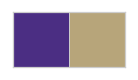

In [561]:
uw = ["#4b2e83", "#b7a57a"]
sns.palplot(sns.color_palette(uw))

Bookings with immigration holds have longer detention time. Using logged time makes this clearer.

In [562]:
hold_order = ['No hold', 'Hold']

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


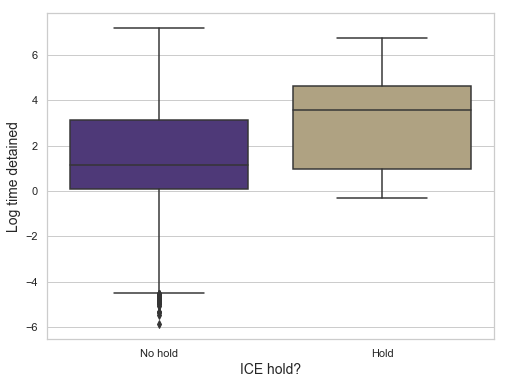

In [563]:
df['imm_hold_text'] = df['imm_hold'].replace({0: 'No hold', 1: 'Hold'})
bplot1 = sns.boxplot(data=df, y='log_time_detained', x='imm_hold_text', palette=uw, order=hold_order)
bplot1.set_xlabel('ICE hold?', fontsize=14)
bplot1.set_ylabel('Log time detained', fontsize=14);

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


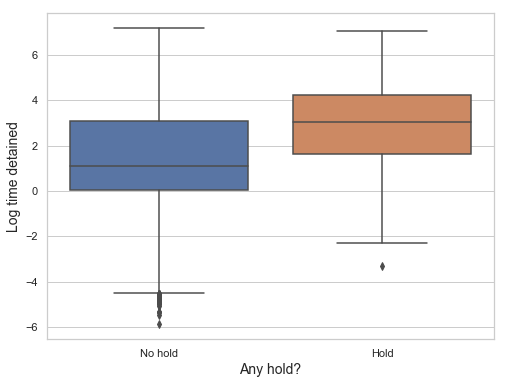

In [564]:
df['all_holds_text'] = df['all_holds'].replace({0: 'No hold', 1: 'Hold'})
bplot1 = sns.boxplot(data=df, y='log_time_detained', x='all_holds_text', order=hold_order)
bplot1.set_xlabel('Any hold?', fontsize=14)
bplot1.set_ylabel('Log time detained', fontsize=14);

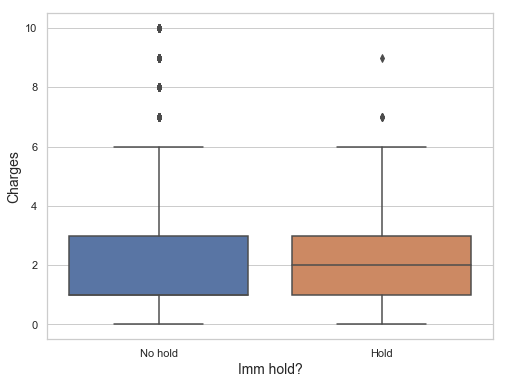

In [565]:
bplot2 = sns.boxplot(data=df, y='charge_topcount', x='imm_hold_text', order=hold_order)
bplot2.set_xlabel('Imm hold?', fontsize=14)
bplot2.set_ylabel('Charges', fontsize=14);

Felonies detained longer.

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


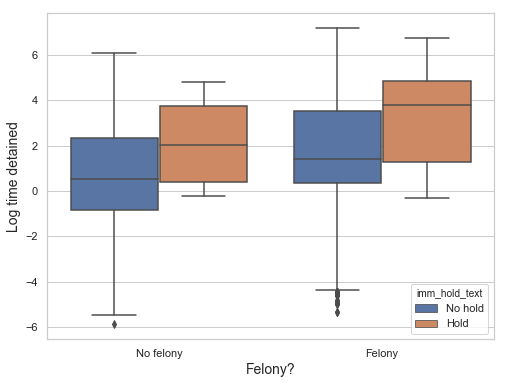

In [566]:
df['felony_text'] = df['felony'].replace({0: 'No felony', 1: 'Felony'})
fel_order = ['No felony', 'Felony']
bplot2 = sns.boxplot(data=df, y='log_time_detained', x='felony_text', hue='imm_hold_text', order=fel_order)
bplot2.set_xlabel('Felony?', fontsize=14)
bplot2.set_ylabel('Log time detained', fontsize=14);

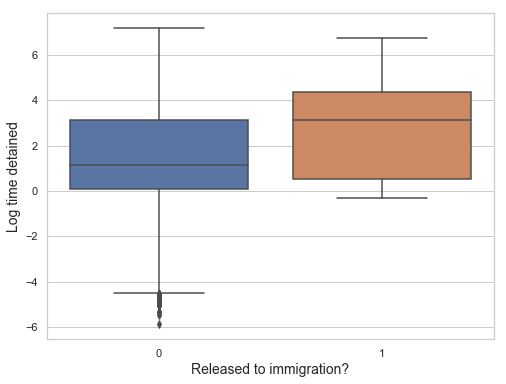

In [567]:
d0 = df[df['release_to_imm'] == 0]['log_time_detained']
d1 = df[df['release_to_imm'] == 1]['log_time_detained']
bplot2 = sns.boxplot(data=[d0, d1])
bplot2.set_xlabel('Released to immigration?', fontsize=14)
bplot2.set_ylabel('Log time detained', fontsize=14);

More serious charges generally detained longer. Lots of outliers for 0 seriousness, probably because it includes holds, community custody, etc.

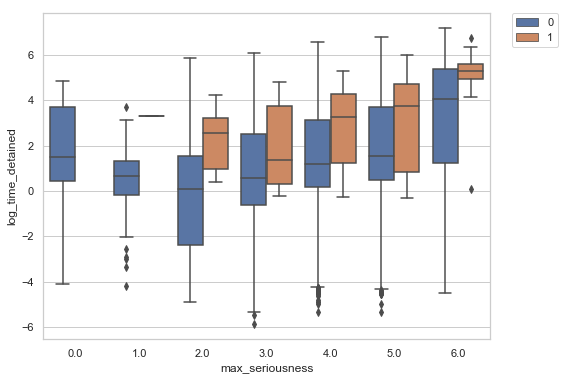

In [568]:
plt = sns.boxplot(data=df, x="max_seriousness", y="log_time_detained", hue='imm_hold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

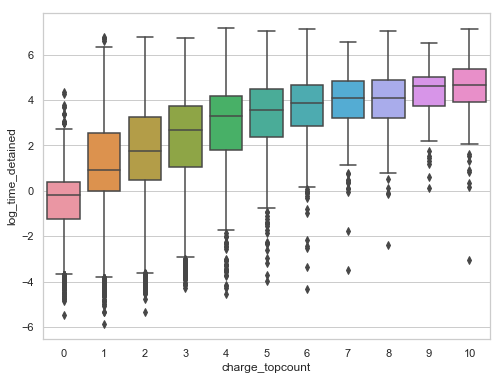

In [569]:
plt = sns.boxplot(data=df, x="charge_topcount", y="log_time_detained")

In [570]:
df['race_desc'].unique()

array(['white', 'black', 'asian/pacific island', 'hispanic',
       'amer indian/alaskan', 'unknown'], dtype=object)

In [571]:
race_order = ['white', 'black', 'hispanic', 'asian/pacific island',
       'amer indian/alaskan', 'unknown']

Heavy `charge_count` bias for `BLACK` and `AMER INDIAN/ALASKAN`, other race categories roughly similar. Using topcounted charges emphasizes this.

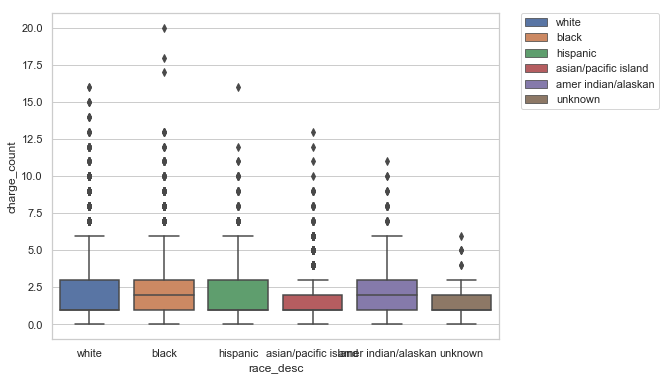

In [572]:
plt = sns.boxplot(data=df, x="race_desc", y="charge_count", hue="race_desc", order=race_order, hue_order=race_order, dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

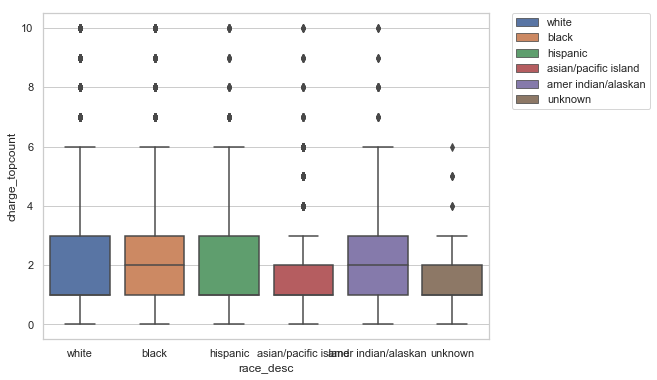

In [573]:
plt = sns.boxplot(data=df, x="race_desc", y="charge_topcount", hue="race_desc", order=race_order, hue_order=race_order, dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Time in detention is roughly similar across race categories.

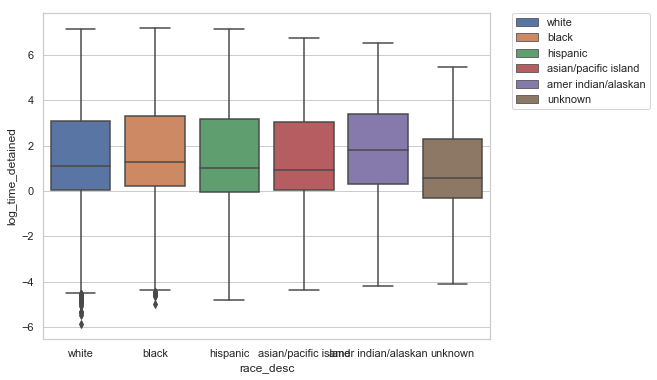

In [574]:
plt = sns.boxplot(data=df, x="race_desc", y="log_time_detained", hue="race_desc", order=race_order, hue_order=race_order, dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [575]:
# plt = sns.boxplot(data=df, x="race_ethnicolr", y="log_time_detained", hue="race_ethnicolr", dodge=False)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [576]:
charge_order = ['drug', 'property', 'public_order', 'sex', 'violent', 'other']

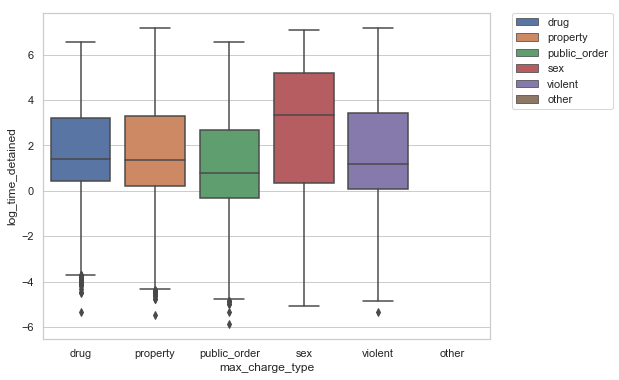

In [577]:
plt = sns.boxplot(data=df, x="max_charge_type", y="log_time_detained", hue="max_charge_type", hue_order=charge_order, order=charge_order, dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

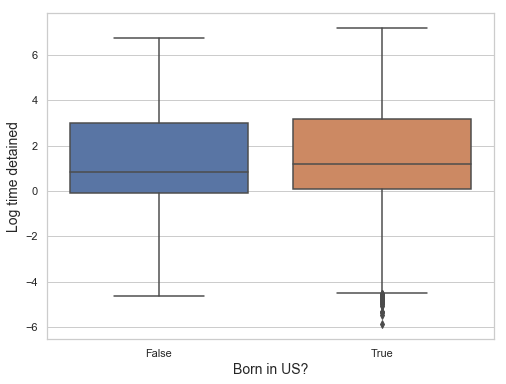

In [578]:
bplot1 = sns.boxplot(data=df, y='log_time_detained', x='born_in_us')
bplot1.set_xlabel('Born in US?', fontsize=14)
bplot1.set_ylabel('Log time detained', fontsize=14);

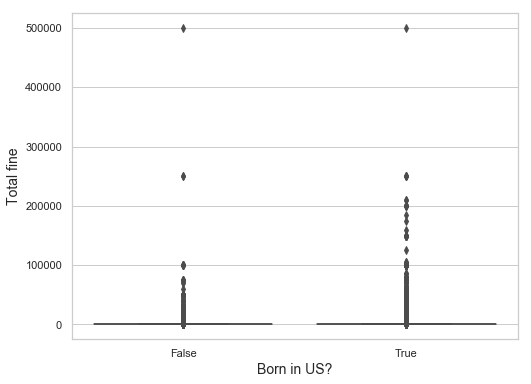

In [579]:
bplot1 = sns.boxplot(data=df, y='total_fine', x='born_in_us')
bplot1.set_xlabel('Born in US?', fontsize=14)
bplot1.set_ylabel('Total fine', fontsize=14);

In [580]:
# bplot1 = sns.boxplot(data=df, y='log_total_fine', x='imm_hold_text')
# bplot1.set_xlabel('Hold status', fontsize=14)
# bplot1.set_ylabel('Log of Total fine', fontsize=14);

In [581]:
df['foreign_born'] = ~df['born_in_us']

/Users/philneff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Regressions

In [582]:
data = df[['time_detained',
           'log_time_detained',
           'imm_hold',
           'charge_topcount',
           'male',
           'female',
           'white',
           'black',
           'hispanic',
           'amer_indian_alaskan',
           'asian_pacific_island',
           'unknown',
           'max_seriousness',
           'public_order',
           'drug',
           'sex',
           'property',
           'violent']]

In [583]:
# Using topcounted charge values
formula = "log_time_detained ~ imm_hold + charge_topcount + male + black + hispanic + amer_indian_alaskan + asian_pacific_island + unknown + max_seriousness + drug + sex + property + violent"
reg = smf.ols(formula = formula, data = df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_time_detained   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     1038.
Date:                Mon, 31 Dec 2018   Prob (F-statistic):               0.00
Time:                        14:25:14   Log-Likelihood:                -59220.
No. Observations:               29313   AIC:                         1.185e+05
Df Residuals:                   29299   BIC:                         1.186e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9139      0.050    -37.985      0.000      -2.013      -1.815
imm_hold                 1.3162      0.137      9.624      0.000       1.048       1.584
charge_topcount          0.5865      0.006     91.167      0.000       0.574       0.599
male                     0.3190      0.025     12.778      0.000       0.270       0.368
black                    0.1268      0.026      4.887      0.000       0.076       0.178
hispanic                -0.0843      0.040     -2.120      0.034      -0.162      -0.006
amer_indian_alaskan      0.3499      0.063      5.572      0.000       0.227       0.473
asian_pacific_island    -0.0248      0.045     -0.546      0.585      -0.114       0.064
unknown                 -0.4300      0.232     -1.851      0.064      -0.885       0.025
max_seriousness          0.4731      0.013     36.114      0.000       0.447       0.499
drug                     0.3036      0.037      8.311      0.000       0.232       0.375
sex                      0.5044      0.086      5.885      0.000       0.336       0.672
property                -0.1588      0.031     -5.197      0.000      -0.219      -0.099
violent                  0.1898      0.031      6.168      0.000       0.129       0.250
==============================================================================
Omnibus:                      678.167   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.140
Skew:                          -0.338   Prob(JB):                    1.30e-168
Kurtosis:                       3.420   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [584]:
reg.pvalues

Intercept              0.00
imm_hold               0.00
charge_topcount        0.00
male                   0.00
black                  0.00
hispanic               0.03
amer_indian_alaskan    0.00
asian_pacific_island   0.58
unknown                0.06
max_seriousness        0.00
drug                   0.00
sex                    0.00
property               0.00
violent                0.00
dtype: float64

In [585]:
# data.describe().T.to_csv('descriptive_stats.csv')

In [587]:
log_time_detained = (reg.params['Intercept'] + 
                    (reg.params['imm_hold'] * 0) + 
                    (reg.params['charge_topcount'] * 2) +
                    (reg.params['male'] * 1) +
                    (reg.params['black'] * 0) +
                    (reg.params['hispanic'] * 1) +
                    (reg.params['amer_indian_alaskan'] * 0) +
                    (reg.params['asian_pacific_island'] * 0) +
                    (reg.params['unknown'] * 0) +
                    (reg.params['max_seriousness'] * 4) +
                    (reg.params['drug'] * 0) +
                    (reg.params['sex'] * 0) +
                    (reg.params['property'] * 0) +
                    (reg.params['violent'] * 0))
predicted_time_detained_0 = np.power(np.e, log_time_detained)
print(f'{predicted_time_detained_0}')

4.000500523717104


In [588]:
log_time_detained = (reg.conf_int()[0]['Intercept'] + 
                    (reg.conf_int()[0]['imm_hold'] * 0) + 
                    (reg.conf_int()[0]['charge_topcount'] * 2) +
                    (reg.conf_int()[0]['male'] * 1) +
                    (reg.conf_int()[0]['black'] * 0) +
                    (reg.conf_int()[0]['hispanic'] * 1) +
                    (reg.conf_int()[0]['amer_indian_alaskan'] * 0) +
                    (reg.conf_int()[0]['asian_pacific_island'] * 0) +
                    (reg.conf_int()[0]['unknown'] * 0) +
                    (reg.conf_int()[0]['max_seriousness'] * 4) +
                    (reg.conf_int()[0]['drug'] * 0) +
                    (reg.conf_int()[0]['sex'] * 0) +
                    (reg.conf_int()[0]['property'] * 0) +
                    (reg.conf_int()[0]['violent'] * 0))
lower_predicted_time_detained_0 = np.power(np.e, log_time_detained)
print(f'{lower_predicted_time_detained_0}')

2.809117595484136


In [589]:
log_time_detained = (reg.conf_int()[1]['Intercept'] + 
                    (reg.conf_int()[1]['imm_hold'] * 0) + 
                    (reg.conf_int()[1]['charge_topcount'] * 2) +
                    (reg.conf_int()[1]['male'] * 1) +
                    (reg.conf_int()[1]['black'] * 0) +
                    (reg.conf_int()[1]['hispanic'] * 1) +
                    (reg.conf_int()[1]['amer_indian_alaskan'] * 0) +
                    (reg.conf_int()[1]['asian_pacific_island'] * 0) +
                    (reg.conf_int()[1]['unknown'] * 0) +
                    (reg.conf_int()[1]['max_seriousness'] * 4) +
                    (reg.conf_int()[1]['drug'] * 0) +
                    (reg.conf_int()[1]['sex'] * 0) +
                    (reg.conf_int()[1]['property'] * 0) +
                    (reg.conf_int()[1]['violent'] * 0))
higher_predicted_time_detained_0 = np.power(np.e, log_time_detained)
print(f'{higher_predicted_time_detained_0}')

5.697164286033608


In [590]:
log_time_detained = (reg.params['Intercept'] + 
                    (reg.params['imm_hold'] * 1) + 
                    (reg.params['charge_topcount'] * 2) +
                    (reg.params['male'] * 1) +
                    (reg.params['black'] * 0) +
                    (reg.params['hispanic'] * 1) +
                    (reg.params['amer_indian_alaskan'] * 0) +
                    (reg.params['asian_pacific_island'] * 0) +
                    (reg.params['unknown'] * 0) +
                    (reg.params['max_seriousness'] * 4) +
                    (reg.params['drug'] * 0) +
                    (reg.params['sex'] * 0) +
                    (reg.params['property'] * 0) +
                    (reg.params['violent'] * 0))
predicted_time_detained_1 = np.power(np.e, log_time_detained)
print(f'{predicted_time_detained_1}')

14.918509271236001


In [591]:
log_time_detained = (reg.conf_int()[0]['Intercept'] + 
                    (reg.conf_int()[0]['imm_hold'] * 1) + 
                    (reg.conf_int()[0]['charge_topcount'] * 2) +
                    (reg.conf_int()[0]['male'] * 1) +
                    (reg.conf_int()[0]['black'] * 0) +
                    (reg.conf_int()[0]['hispanic'] * 1) +
                    (reg.conf_int()[0]['amer_indian_alaskan'] * 0) +
                    (reg.conf_int()[0]['asian_pacific_island'] * 0) +
                    (reg.conf_int()[0]['unknown'] * 0) +
                    (reg.conf_int()[0]['max_seriousness'] * 4) +
                    (reg.conf_int()[0]['drug'] * 0) +
                    (reg.conf_int()[0]['sex'] * 0) +
                    (reg.conf_int()[0]['property'] * 0) +
                    (reg.conf_int()[0]['violent'] * 0))
lower_predicted_time_detained_1 = np.power(np.e, log_time_detained)
print(f'{lower_predicted_time_detained_1}')

8.012451138453546


In [592]:
log_time_detained = (reg.conf_int()[1]['Intercept'] + 
                    (reg.conf_int()[1]['imm_hold'] * 1) + 
                    (reg.conf_int()[1]['charge_topcount'] * 2) +
                    (reg.conf_int()[1]['male'] * 1) +
                    (reg.conf_int()[1]['black'] * 0) +
                    (reg.conf_int()[1]['hispanic'] * 1) +
                    (reg.conf_int()[1]['amer_indian_alaskan'] * 0) +
                    (reg.conf_int()[1]['asian_pacific_island'] * 0) +
                    (reg.conf_int()[1]['unknown'] * 0) +
                    (reg.conf_int()[1]['max_seriousness'] * 4) +
                    (reg.conf_int()[1]['drug'] * 0) +
                    (reg.conf_int()[1]['sex'] * 0) +
                    (reg.conf_int()[1]['property'] * 0) +
                    (reg.conf_int()[1]['violent'] * 0))
higher_predicted_time_detained_1 = np.power(np.e, log_time_detained)
print(f'{higher_predicted_time_detained_1}')

27.777007938036622


In [593]:
print(f'Predicted time multiple: {predicted_time_detained_1 / predicted_time_detained_0}\
      ({lower_predicted_time_detained_1 / lower_predicted_time_detained_0}, \
     {higher_predicted_time_detained_1 / higher_predicted_time_detained_0})')

Predicted time multiple: 3.7291606844671334      (2.852301787342101,      4.875584860020791)


In [594]:
print(predicted_time_detained_1 - predicted_time_detained_0)
print(lower_predicted_time_detained_1 - lower_predicted_time_detained_0)
print(higher_predicted_time_detained_1 - higher_predicted_time_detained_0)

10.918008747518897
5.2033335429694105
22.079843652003014


In [616]:
df.loc[(df['imm_hold'] == 0) &
       (df['hispanic'] == 1) &
       (df['max_seriousness'] >= 4) &
       (df['charge_topcount'] >= 2) &
       (df['male'] == 1) &
       (df['public_order'] == 1)]['time_detained'].mean()

52.89990997942387

In [613]:
df.loc[(df['imm_hold'] == 1) &
       (df['hispanic'] == 1) &
       (df['max_seriousness'] >= 4) &
       (df['charge_topcount'] >= 2) &
       (df['male'] == 1) &
       (df['public_order'] == 1)]

,booking_dt,release_dt,booking_charge_desc,booking_charge_txt,charge_release_dt,title_txt,cause_num,jurisdiction_cd,release_disposition_desc,post_flg,...,misdemeanor,total_fine,paid_bail,at_least_one_other_type,all_holds,imm_hold_text,felony_misdemeanor,all_holds_text,felony_text,foreign_born
booking_id,,,,,,,,,,,,,,,,,,,,,
1fba618ef09195b518348977fbd5a811222f6841,2017-10-02 12:44:00,2018-01-12 07:00:00,DWI,NaN,2017-10-18 15:13:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",7ZC003051,PD1,Credit for Time Served,N,...,0,0.00,False,1,1,Hold,Felony,Hold,Felony,True
52cc822b58679aafd73e5e0120f132a9f21f812b,2017-11-23 00:16:00,2017-11-28 12:00:00,DWLS/DWLR,3RD,2017-11-27 15:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",NaN,PD1,"NCF, Pending Inv",N,...,0,0.00,False,1,1,Hold,Felony,Hold,Felony,True
5910dc7c2845af13894b7a836d1c17daf5c27199,2016-05-29 22:14:00,2017-07-09 10:40:00,DWI,NaN,2016-11-21 08:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",15L294,LKM,Time Served,N,...,0,0.00,False,1,1,Hold,Felony,Hold,Felony,True
9a54a7a2101e4bcaa7e2208ea1e459e8f554b4bd,2017-08-30 01:15:00,2018-01-09 20:23:00,HOLD IMMIGRAT,NaN,2018-01-09 20:30:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",NaN,IMM,Immigration,N,...,0,0.00,False,1,1,Hold,Felony,Hold,Felony,True
aa55ae8593812ab4971d516d78ef8a15b0f3175e,2018-04-30 04:07:00,2018-06-29 08:56:00,DUI W/ PRIOR CONVICTION,NaN,2018-06-29 08:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",B00257007,TACM,Time Served,N,...,0,0.00,False,1,1,Hold,Felony,Hold,Felony,True
b688d25c48bb38df36c2d2f334008ca31a0df82d,2017-06-24 05:03:00,2017-10-16 11:15:00,DWLS/DWLR,NaN,2017-09-26 22:00:00,"Report Criteria: 10/01/2017 to 07/31/2018, Dis...",7ZC001748,PD1,Court Order,N,...,0,0.00,False,1,1,Hold,Felony,Hold,Felony,True
de32cf3e02718589ceb83c5594e0084e2e2406fc,2017-03-21 09:08:00,2017-05-31 18:15:00,HOLD IMMIGRAT,NaN,2017-05-31 18:00:00,"Report Criteria: 10/01/2016 to 09/30/2017, Dis...",NaN,IMM,Immigration,N,...,0,0.00,False,1,1,Hold,Felony,Hold,Felony,True


In [595]:
(np.power(np.e, reg.params) - 1) * 100

Intercept              -85.25
imm_hold               272.92
charge_topcount         79.77
male                    37.58
black                   13.52
hispanic                -8.08
amer_indian_alaskan     41.89
asian_pacific_island    -2.45
unknown                -34.95
max_seriousness         60.50
drug                    35.47
sex                     65.59
property               -14.68
violent                 20.90
dtype: float64

In [596]:
(np.power(np.e, reg.conf_int()) - 1) * 100

,0,1
Intercept,-86.64,-83.72
imm_hold,185.23,387.56
charge_topcount,77.52,82.05
male,31.01,44.48
black,7.89,19.45
hispanic,-14.97,-0.63
amer_indian_alaskan,25.46,60.48
asian_pacific_island,-10.76,6.63
unknown,-58.73,2.56
max_seriousness,56.43,64.67


In [597]:
# Testing that this is same formula used by Beckett/Evans
(np.power(np.e, .993) - 1) * 100

169.93202984410792

# Simple calculation of extra cost

In [ ]:
cost_per_day = 126

In [ ]:
df = df.copy()
df.loc[:,'approx_cost'] = df['time_detained'] * 126
df.loc[:,'approx_cost_no_hold'] = df['predicted_time_detained_no_hold'] * 126

In [ ]:
non_detainer_mean_time = df[df['imm_hold'] == 0]['time_detained'].mean()
non_detainer_avg_cost =  non_detainer_mean_time * 126
detainer_mean_time = df[df['imm_hold'] == 1]['time_detained'].mean()
detainer_avg_cost =  detainer_mean_time * 126

In [ ]:
diff = detainer_mean_time - non_detainer_mean_time
diff

In [ ]:
non_detainer_avg_cost

In [ ]:
detainer_avg_cost

In [ ]:
extra_cost_per_detainer = detainer_avg_cost - non_detainer_avg_cost

In [ ]:
extra_cost_per_detainer

In [ ]:
total_extra_cost = extra_cost_per_detainer * len(df[df['imm_hold'] == 1])

In [ ]:
total_extra_cost

# Regressions on subsets of records

In [ ]:
df.set_index('release_dt',inplace=True)

In [ ]:
# 2017 records only
reg = smf.ols(formula = formula, data = df['2017']).fit()
reg.summary()

In [ ]:
# 2018 records only
reg = smf.ols(formula = formula, data = df['2018']).fit()
reg.summary()

In [ ]:
quarters = ['2016-Q4',
            '2017-Q1',
            '2017-Q2',
            '2017-Q3',
            '2017-Q4',
            '2018-Q1',
            '2018-Q2']

In [ ]:
def report():
    param_values = []
    for q in quarters:
        reg = smf.ols(formula = formula, data = df[f'{q}']).fit()
        param_values.append(list(reg.params))
    report = pd.DataFrame(data=param_values, index=quarters, columns=list(reg.params.index))
    return(report.T)

In [ ]:
report()

In [ ]:
for q in quarters:
    reg = smf.ols(formula = formula, data = df[f'{q}']).fit()
    print(f'{q}\n{reg.summary()}\n')

In [ ]:
for q in quarters:
    df_subset = df[f'{q}']
    hold = df_subset['imm_hold'] == 1
    print(q, df_subset[hold]['time_detained'].max())

In [ ]:
df[df['time_detained'] > 849]

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df['quarter'] = df['release_dt'].map(lambda x: f"{x.year}-Q{x.quarter}")

In [ ]:
df['quarter'].unique()

In [ ]:
df.set_index('release_dt', inplace=True)

In [ ]:
df.sort_index(inplace=True)

In [ ]:
sns.set(style="ticks")

In [ ]:
g = sns.catplot(data=df, col='quarter', col_wrap=3, x='imm_hold', y='log_time_detained', kind='box')

In [ ]:
g = sns.catplot(data=df, col='race_desc', col_wrap=2, x='imm_hold', y='log_time_detained', hue='race_desc', kind='box', dodge=False)

In [ ]:
g = sns.catplot(data=df, col='quarter', col_wrap=3, x='charge_topcount', y='log_time_detained', kind='box')

In [ ]:
g = sns.catplot(data=df,
                col='quarter',
                col_wrap=3,
                x='max_seriousness',
                y='log_time_detained',
                kind='box')

## Regression using ethnicolr

In [ ]:
# Using ethnicolr race predictions
formula_ethnicolr = "log_time_detained ~ imm_hold + charge_topcount + male + nh_black_ethnicolr + hispanic_ethnicolr + asian_ethnicolr + max_seriousness + felony + drug + sex + property + violent + other"
reg_ethnicolr = smf.ols(formula = formula_ethnicolr, data = df).fit()
reg_ethnicolr.summary()

In [ ]:
(np.power(np.e, reg_ethnicolr.params) - 1) * 100

# Plotting trends

In [ ]:
df.reset_index(inplace=True)
df.set_index('release_dt', inplace=True)

In [ ]:
monthly = df['release_to_imm'].resample('M').sum()
quarterly = df['release_to_imm'].resample('Q').sum()

In [ ]:
quarterly.plot()

In [ ]:
quarterly

## Regression for all holds

In [ ]:
# Using topcounted charge values
all_holds_formula = "log_time_detained ~ all_holds + charge_topcount + male + black + hispanic + amer_indian_alaskan + asian_pacific_island + unknown + max_seriousness + felony + drug + sex + property + violent + other"
all_holds_reg = smf.ols(formula = all_holds_formula, data = df).fit()
all_holds_reg.summary()

In [ ]:
(np.power(np.e, all_holds_reg.params) - 1) * 100